In [1]:
import pybaseball as pb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.ticker
import os

In [2]:
# First, import and extrapolate projections for the rest of 2025

batters_2025 = pb.batting_stats(2025, qual = 100)

In [6]:
batters_2025['WAR/game'] = batters_2025['WAR']/batters_2025['G']
games_left =162- max(batters_2025['G'])
batters_2025['WAR_left'] = batters_2025['WAR/game']*games_left
batters_2025['proj_total_war'] = batters_2025['WAR']+batters_2025['WAR_left']

In [ ]:
#next, load batters 1920-present.  use pb.cache()

In [8]:
pb.cache.enable()

In [53]:
batters_1 = pb.batting_stats(start_season = 1920, end_season = 1980 ,league = 'AL', qual=200)

In [55]:
batters_2 = pb.batting_stats(start_season = 1980, end_season = 2024, league='AL', qual=200)

In [56]:
batters_3 = pb.batting_stats(start_season = 1920, end_season = 1980 ,league = 'NL', qual=200)

In [57]:
batters_4 = pb.batting_stats(start_season = 1980, end_season = 2024, league='NL', qual=200)

In [87]:
batters_df = pd.concat([batters_1, batters_2, batters_3, batters_4])

In [88]:
batters_df = batters_df.drop_duplicates()

In [89]:
batters_df

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
2,1011327,1923,Babe Ruth,NYY,28,152,522,699,205,106,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,14.7
1,1011327,1921,Babe Ruth,NYY,26,152,540,693,204,85,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,13.7
0,1011327,1920,Babe Ruth,NYY,25,142,457,615,172,73,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,13.1
6,1011327,1927,Babe Ruth,NYY,32,151,540,691,192,95,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,12.9
7,1004598,1927,Lou Gehrig,NYY,24,155,584,717,218,101,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,12.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,763,2001,Peter Bergeron,MON,23,102,375,416,79,61,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-2.4
6584,45,2012,Rod Barajas,PIT,36,104,321,361,66,44,...,NaN,0.0,NaN,0,0.147,0.258,NaN,NaN,NaN,-2.6
6881,1008513,1999,Willie McGee,STL,40,132,271,290,68,61,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-2.6
1116,2113,2008,Ryan Doumit,PIT,27,116,431,465,137,88,...,NaN,0.0,NaN,0,0.144,0.231,NaN,NaN,NaN,-3.1


In [90]:
#Filter to AL/NL players only, filter for important cols only


batters_df = batters_df.loc[:,['IDfg','Season','Name','Age','WAR']]

In [91]:
batters_df

,IDfg,Season,Name,Age,WAR
2,1011327,1923,Babe Ruth,28,14.7
1,1011327,1921,Babe Ruth,26,13.7
0,1011327,1920,Babe Ruth,25,13.1
6,1011327,1927,Babe Ruth,32,12.9
7,1004598,1927,Lou Gehrig,24,12.4
...,...,...,...,...,...
6978,763,2001,Peter Bergeron,23,-2.4
6584,45,2012,Rod Barajas,36,-2.6
6881,1008513,1999,Willie McGee,40,-2.6
1116,2113,2008,Ryan Doumit,27,-3.1


In [92]:
#process 2025 data
batters_2025_trimmed = batters_2025.loc[:,['IDfg','Name', 'Season','Age','proj_total_war']]
batters_2025_trimmed=batters_2025_trimmed.rename(columns={'proj_total_war':'WAR'})

In [93]:
all_batters = pd.concat([batters_df, batters_2025_trimmed])

In [95]:
all_batters.to_csv('all_batters.csv')

In [ ]:
#saved to CSV so we can reload the notebook without re-aqcuiring the data

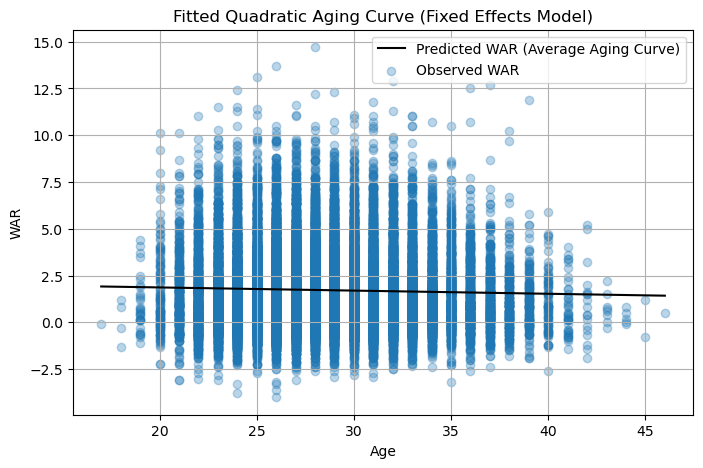

In [113]:
# first, try a simple linear fit

from statsmodels.formula.api import ols

simple_linear = ols('WAR~Age', data=all_batters).fit()

# Graph this, and check diagnostics
intercept = simple_linear.params['Intercept']
coef_age = simple_linear.params['Age']
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + (coef_age * age_range)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)',color='black')
plt.scatter(all_batters['Age'], all_batters['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Fixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

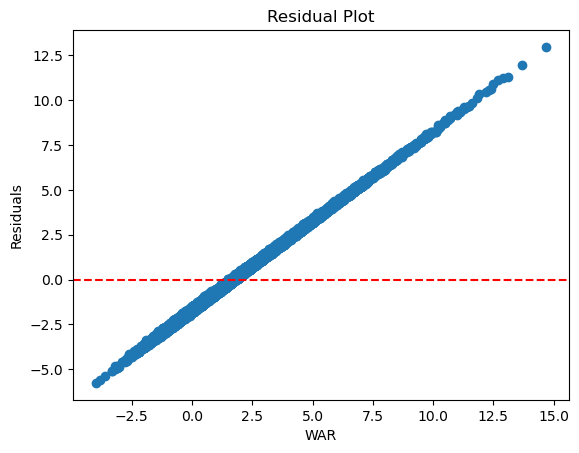

In [114]:
#this model is obviously bad, and we expect it to be.  check residual plot anyway
plt.scatter(all_batters['WAR'], simple_linear.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('WAR')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

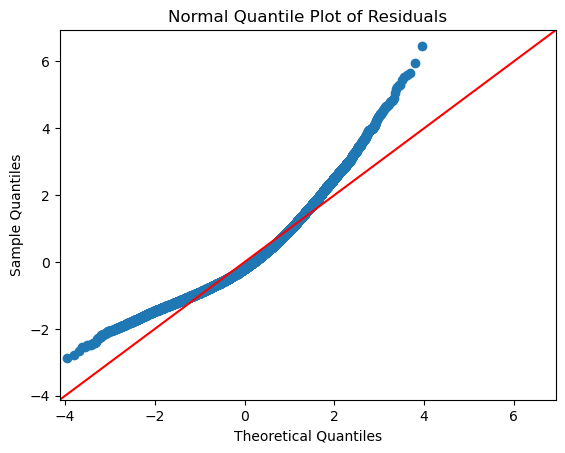

In [115]:
#qqplot
from statsmodels.api import qqplot
qqplot(simple_linear.resid, line='45', fit=True)
plt.title('Normal Quantile Plot of Residuals')
plt.show()

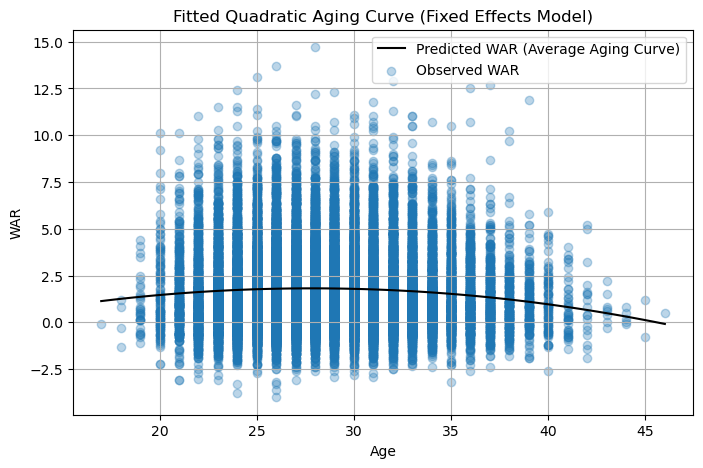

In [116]:
#We expect the true relationship to be quadratic, so we can use a quadratic fit
all_batters['Age2'] = all_batters['Age']**2

quadratic = ols('WAR~Age+Age2', data=all_batters).fit()

# Graph this, and check diagnostics
intercept = quadratic.params['Intercept']
coef_age = quadratic.params['Age']
coef_age2 = quadratic.params['Age2']
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)',color='black')
plt.scatter(all_batters['Age'], all_batters['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Fixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

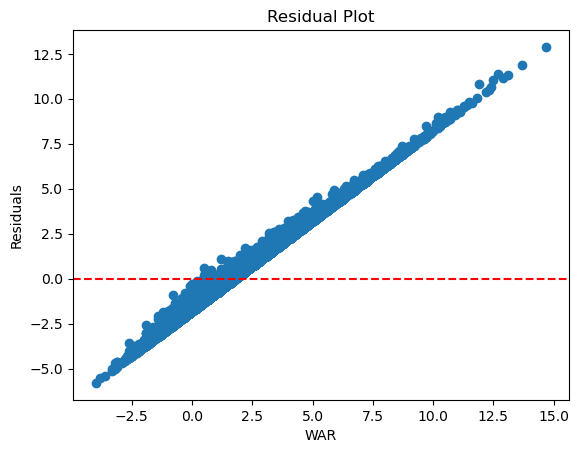

In [117]:
plt.scatter(all_batters['WAR'], quadratic.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('WAR')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

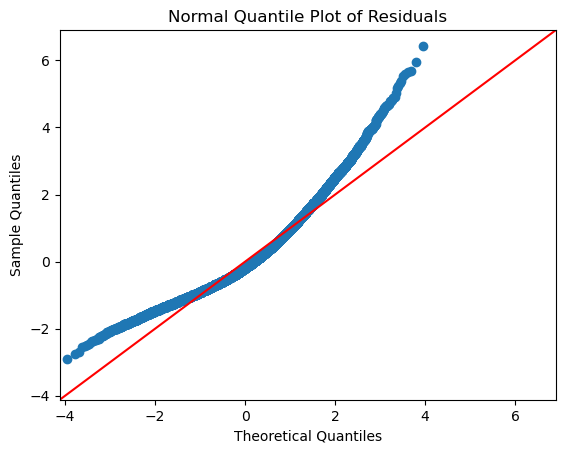

In [118]:
qqplot(quadratic.resid, line='45', fit=True)
plt.title('Normal Quantile Plot of Residuals')
plt.show()

In [119]:
#This model still isn't enough.  We are not accounting for the effect of an individual player.  We can try this with a fixed effects model.
#To do this, we must remove all players with fewer than 3 seasons
all_batters_fe = all_batters.groupby('IDfg').filter(lambda x: len(x) > 3)
batter_fixedeffects = ols('WAR~Age+Age2+C(IDfg)', data=all_batters_fe).fit()

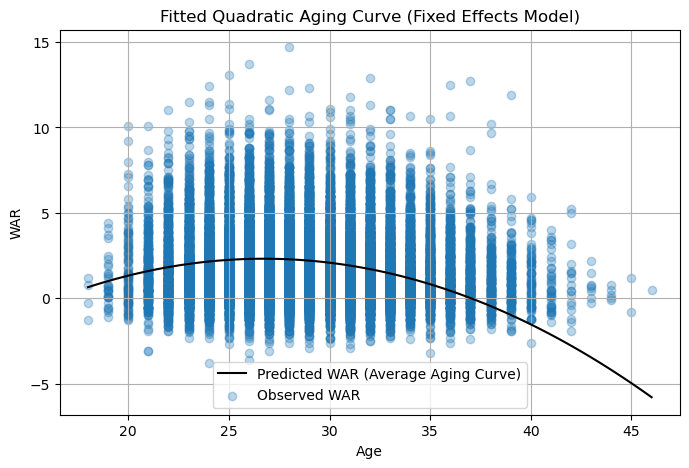

In [123]:
intercept = batter_fixedeffects.params['Intercept']
coef_age = batter_fixedeffects.params['Age']
coef_age2 = batter_fixedeffects.params['Age2']
age_range = np.linspace(all_batters_fe['Age'].min(), all_batters_fe['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)',color='black')
plt.scatter(all_batters_fe['Age'], all_batters_fe['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Fixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

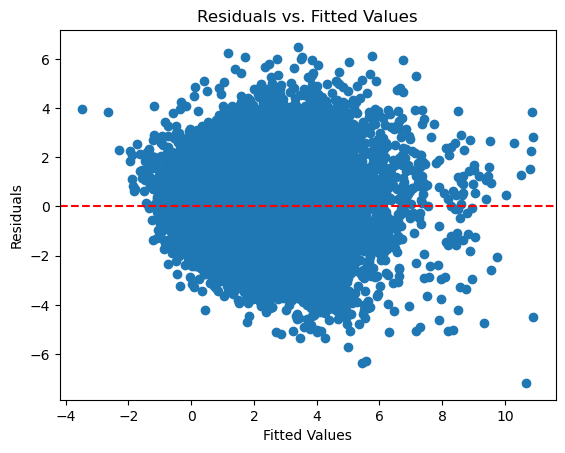

In [124]:
plt.scatter(batter_fixedeffects.fittedvalues, batter_fixedeffects.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

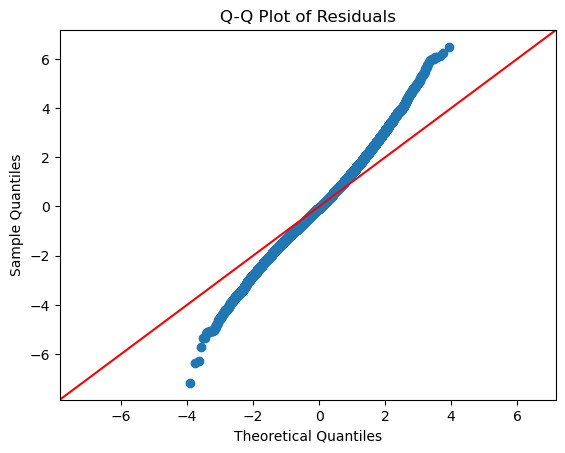

In [125]:
qqplot(batter_fixedeffects.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [ ]:
# This is still the incorrect model, as we can see in the residual plots.  We can try the random-effects model next

In [126]:
from statsmodels.formula.api import mixedlm

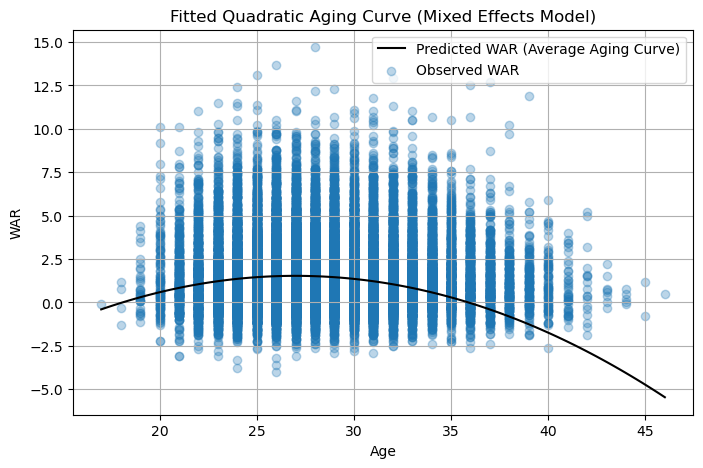

In [132]:
batter_mixed = mixedlm("WAR ~ Age + Age2", data=all_batters, groups=all_batters["IDfg"]).fit()
intercept = batter_mixed.params['Intercept']
coef_age = batter_mixed.params['Age']
coef_age2 = batter_mixed.params['Age2']
age_range = np.linspace(batters_df['Age'].min(), batters_df['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)', color='black')
plt.scatter(batters_df['Age'], batters_df['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Mixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

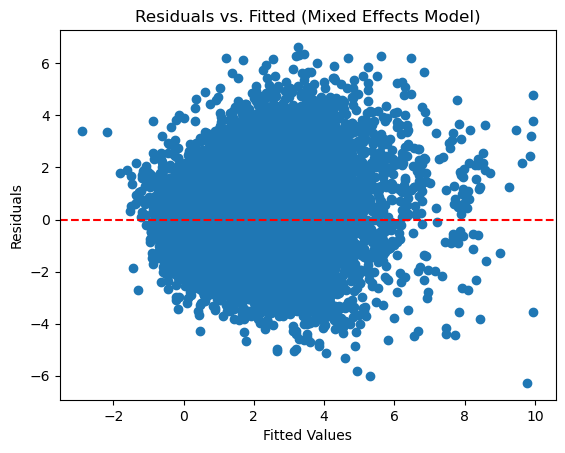

In [133]:
plt.scatter(batter_mixed.fittedvalues, batter_mixed.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Mixed Effects Model)')
plt.show()

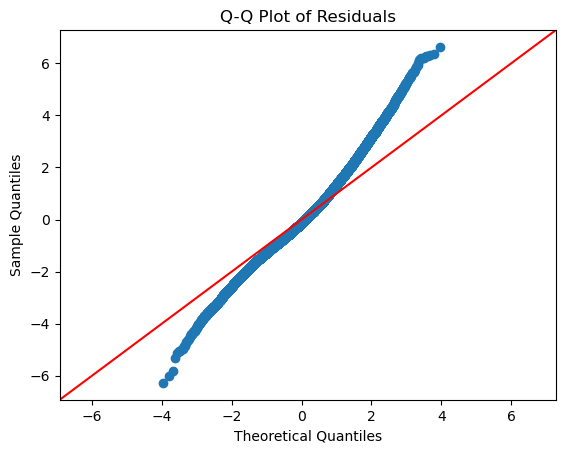

In [134]:
qqplot(batter_mixed.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

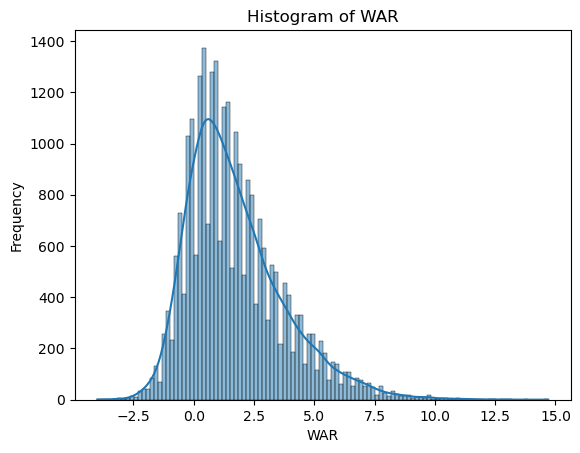

In [136]:
sns.histplot(all_batters['WAR'], kde=True)
plt.title('Histogram of WAR')
plt.xlabel('WAR')
plt.ylabel('Frequency')
plt.show()

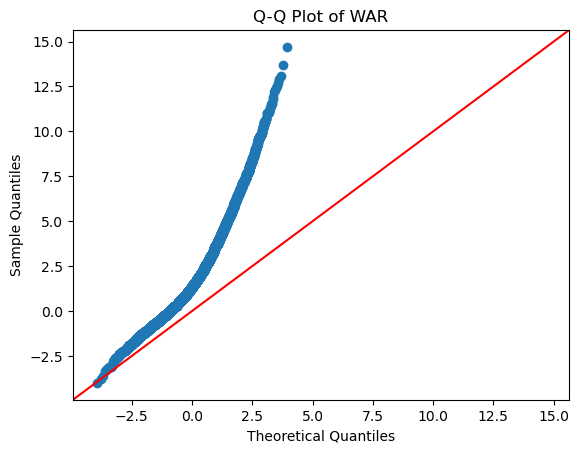

In [137]:
qqplot(all_batters['WAR'], line='45')
plt.title('Q-Q Plot of WAR')
plt.show()

In [ ]:
# Now we can see the actual response variable is nonlinear.  We can account for this with the Box-Cox or Yeo-Johnson tranformations.

In [147]:
from scipy.stats import boxcox

shift = abs(all_batters['WAR'].min()) + 1
war_shifted = all_batters['WAR'] + shift

all_batters['WAR_boxcox'], lam = boxcox(war_shifted)
print(f'Optimal lambda for Box-Cox: {lam:.3f}')

Optimal lambda for Box-Cox: -0.137


In [148]:
from statsmodels.regression.mixed_linear_model import MixedLM
batter_mixed_boxcox = MixedLM.from_formula(
    "WAR_boxcox ~ Age + Age2",
    groups=all_batters["IDfg"],
    data=all_batters
).fit()

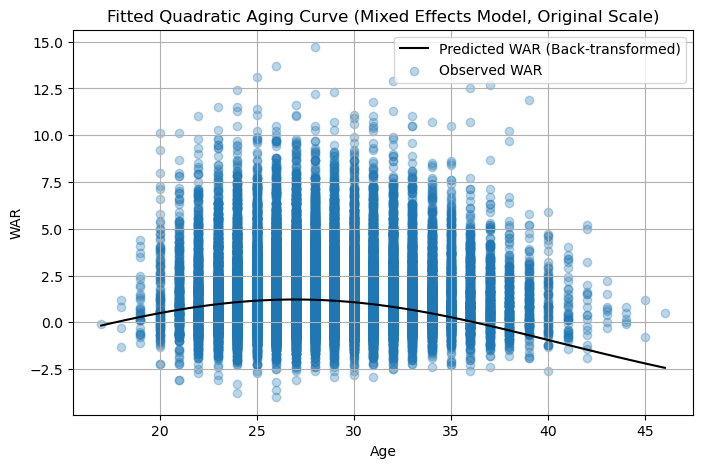

In [149]:
from scipy.special import inv_boxcox
predicted_transformed_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
intercept = batter_mixed_boxcox.params['Intercept']
coef_age = batter_mixed_boxcox.params['Age']
coef_age2 = batter_mixed_boxcox.params['Age2']
age_range = np.linspace(batters_df['Age'].min(), batters_df['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
predicted_war_original = inv_boxcox(predicted_transformed_war, lam) - shift

plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war_original, label='Predicted WAR (Back-transformed)', color='black')
plt.scatter(batters_df['Age'], batters_df['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Mixed Effects Model, Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

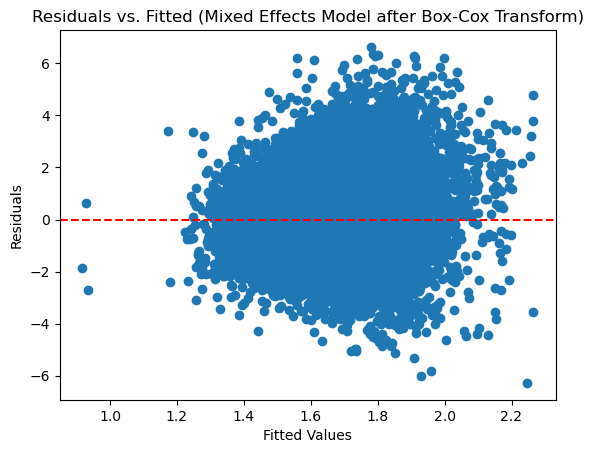

In [150]:
plt.scatter(batter_mixed_boxcox.fittedvalues, batter_mixed.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Mixed Effects Model after Box-Cox Transform)')
plt.show()

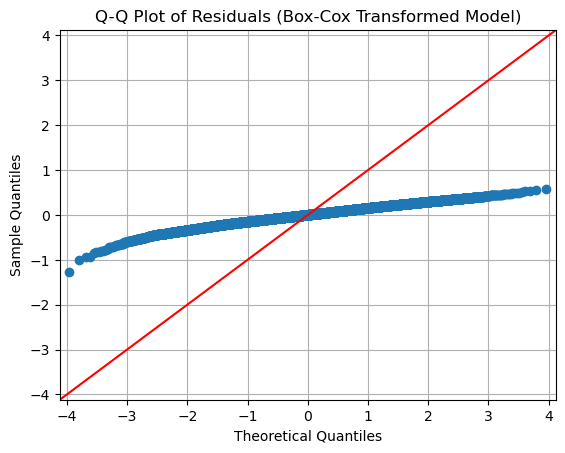

In [151]:
qqplot(batter_mixed_boxcox.resid, line='45')
plt.title('Q-Q Plot of Residuals (Box-Cox Transformed Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()